In [1]:
# Install third party / library
!pip install torchsummary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Library for accessing google drive
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

In [ ]:
# Import library
import os                       # for working with files
import numpy as np              # for numerical computationss
import pandas as pd             # for working with dataframes
import torch                    # Pytorch module 
import matplotlib.pyplot as plt # for plotting informations on graph and images using tensors
import torch.nn as nn           # for creating  neural networks
from torch.utils.data import DataLoader # for dataloaders 
from PIL import Image           # for checking images
import torch.nn.functional as F # for functions for calculating loss
import torchvision.transforms as transforms   # for transforming images into tensors 
from torchvision.utils import make_grid       # for data checking
from torchvision.datasets import ImageFolder  # for working with classes and images
from torchsummary import summary              # for getting the summary of our model

%matplotlib inline

## Data Preparation,Preprocessing


### Exploring Data

In [ ]:
# Define data directory for train and validation data
data_dir = "/content/drive/MyDrive/TA-GROUP11/DATASET"
train_dir = data_dir + "/DATA_TRAINING"
valid_dir = data_dir + "/DATA_VALID"
corn_diseases = os.listdir(train_dir)
corn_diseases_valid = os.listdir(valid_dir)
corn_diseases

In [ ]:
# Get all disesase name from Corn
corn_diseases.sort()
for path in corn_diseases:
    print(path + " => " + str(len(os.listdir(train_dir +'/'+ path))))

In [ ]:
# Let's Calculate total files from disease corn
train_total = 0
valid_total = 0
for path in corn_diseases:
    train_total += len(os.listdir(train_dir +'/'+ path))
for path in corn_diseases_valid:
    valid_total += len(os.listdir(valid_dir +'/'+ path))
print("Total of Disease Classes : %d"%len(corn_diseases))
print("Total all traine files : %d => %.2f"%(train_total,train_total/(train_total+valid_total)))
print("Total all valid files : %d => %.2f"%(valid_total,valid_total/(train_total+valid_total)))


In [ ]:
# Number of images for each disease
nums = {}
print("Train Dataframe")
for disease in corn_diseases:
    nums[disease] = len(os.listdir(train_dir + '/' + disease))

img_per_class = pd.DataFrame(nums.values(), index=nums.keys(), columns=["no. of images"])
img_per_class

    
# converting the nums dictionary to pandas dataframe passing index as plant name and number of images as column

In [ ]:
nums = {}
print("Valid Dataframe")
for disease in corn_diseases_valid: 
    nums[disease] = len(os.listdir(valid_dir + '/' + disease))

img_per_class = pd.DataFrame(nums.values(), index=nums.keys(), columns=["no. of images"])
img_per_class

In [ ]:
print(nums.values())

### Data Visualization (membantu memahami data kita)

In [ ]:
# plotting number of images available for each disease
def show_plot(data):
    index = [n for n in range(len(data))]
    plt.figure(figsize=(20, 5))
    plt.bar(index, [n for n in nums.values()], width=0.3)
    plt.xlabel('Plants/Diseases', fontsize=10)
    plt.ylabel('No of images available', fontsize=10)
    plt.xticks(index, data, fontsize=15, rotation=90)
    plt.title('Images per each class of plant disease')
show_plot(corn_diseases)

Ya udah bisalah, setiap kelas size of data nya udah hampir sama, mungkin nanti bakal disamakan lagi biar performance lebih baik

In [ ]:
# Helper, check available image for training data
n_train = 0
for value in nums.values():
    n_train += value
print(f"There are {n_train} images for training")

### Data Preparation and Preprocessing for training





In [ ]:
batch_size = 32
crop_size = 256

train_transform = transforms.Compose([
  transforms.RandomRotation(15),
  transforms.RandomResizedCrop(crop_size, scale = (0.8,1.0)),
  transforms.RandomHorizontalFlip(),
  transforms.ToTensor()
])
valid_transform = transforms.Compose([
  transforms.Resize(256),
  transforms.CenterCrop(crop_size),
  transforms.ToTensor()
])

In [ ]:
# datasets for validation and training
# https://pytorch.org/vision/main/generated/torchvision.datasets.ImageFolder.html
# root fill using root dir, untuk hal ini train_dir dan valid_dir
# tranform using ToTensor()
# Return ImageFolder and transforms to Tensor
# ToTensor = Convert a PIL image PIL Image or numpy.ndarray (H x W x C) in the range [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0] 
# if the PIL Image belongs to one of the modes (L, LA, P, I, F, RGB, YCbCr, RGBA, CMYK, 1) 
# or if the numpy.ndarray has dtype = np.uint8 
train = ImageFolder(train_dir, transform=train_transform)
valid = ImageFolder(valid_dir, transform=valid_transform)

In [ ]:
# check  type
#Helper doang
print([type(train),type(valid)])

In [ ]:
img, label = train[0]
print(img.shape, label)
# We can see the shape (3, 256 256) of the image. 3 is the number of channels (RGB) and 256 x 256 
# is the width and height of the image

In [ ]:
# total number of classes in train set
# Helper
len(train.classes)

In [ ]:
# plotting the original image and the RGB channels
def show_plot(image,label):
  f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, sharey=True)
  f.set_figwidth(15)
  ax1.imshow(image.permute(1, 2, 0))

  # RGB channels
  # CHANNELID : 0 for Red, 1 for Green, 2 for Blue. 
  ax2.imshow(image.permute(1, 2, 0)[:, :, 0]) #Red
  ax3.imshow(image.permute(1, 2, 0)[:, : , 1]) #Green
  ax4.imshow(image.permute(1, 2, 0)[:, : , 2]) #Blue
  f.suptitle('Different Channels of Image')

In [ ]:
# For Remove
img, label =  train[-1]
print(img.shape,label)
print(img[1, :, 3])

In [ ]:
show_plot(*train[1])

In [ ]:
# for checking some images from training dataset
# Helper funciton
def show_image(image, label):
    print("Label :" + train.classes[label] + "(" + str(label) + ")")
    plt.imshow(image.permute(1, 2, 0))

#### Show feature array from images

In [ ]:
img,label = train[1]
img = img.numpy()
img = np.squeeze(img[0,:,:])

fig = plt.figure(figsize = (12,12)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')
width, height = img.shape
thresh = img.max()/2.5
for x in range(width):
    for y in range(height):
        val = round(img[x][y],2) if img[x][y] !=0 else 0
        ax.annotate(str(val), xy=(y,x),
            color='white' if img[x][y]<thresh else 'black')

#### Try to show sample data image

In [ ]:
show_image(*train[0])

In [ ]:
show_image(*train[1])

In [ ]:
show_image(*train[len(corn_diseases)-1])

In [ ]:
show_image(*train[2000])

In [ ]:
# Setting the seed value
# https://pytorch.org/docs/stable/generated/torch.manual_seed.html
#  generate randoom_number
# rentang : [-0x8000_0000_0000_0000, 0xffff_ffff_ffff_ffff]
random_seed = 7
torch.manual_seed(random_seed)

In [ ]:
# setting the batch size
batch_size = 32
"""
batch_size is the total number of images given as input at once in forward propagation of the CNN. 
Basically, batch size defines the number of samples that will be propagated through the network.

For instance, let's say you have 1050 training samples and you want to set up a batch_size equal to 100. 
The algorithm takes the first 100 samples (from 1st to 100th) from the training dataset and trains the network. 
Next, it takes the second 100 samples (from 101st to 200th) and trains the network again. 
We can keep doing this procedure until we have propagated all samples through of the network.
"""

In [ ]:
# DataLoaders for training and validation
train_dl = DataLoader(train, batch_size, shuffle=True, num_workers=2, pin_memory=True)
valid_dl = DataLoader(valid, batch_size, num_workers=2, pin_memory=True)

In [ ]:
# helper function to show a batch of training instances
def show_batch(data,nrow = 8):
    for images, labels in data:
        fig, ax = plt.subplots(figsize=(30, 30))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow).permute(1, 2, 0))
        break

In [ ]:
# Images for first batch of training
show_batch(train_dl,8)

## Modelling :"""

Harap menggunakan GPU :"
Karena memerlukan komputasi yang besar, GPU dapat melakukan processing secara async untuk banyak thread

In [ ]:
# for moving data into GPU (if available)
#  From internet ot check, device kita menggunakan GPU atau CPU
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available:
        return torch.device("cuda")
    else:
        return torch.device("cpu")

# for moving data to device (CPU or GPU)
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

# for loading in the device (GPU if available else CPU)
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)
        
    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = get_default_device()
device


### Building Model Architecture....

### Define Restnet9 Model

In [ ]:
class SimpleResidualBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.conv2(out)
        return self.relu2(out) + x # ReLU can be applied before or after adding the input

In [ ]:
# for calculating the accuracy
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


# base class for the model
class ImageClassificationBase(nn.Module):
    
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                   # Generate prediction
        loss = F.cross_entropy(out, labels)  # Calculate loss
        acc = accuracy(out, labels)          # Calculate accuracy
        return {"val_loss": loss.detach(), "val_accuracy": acc}
    
    def validation_epoch_end(self, outputs):
        batch_losses = [x["val_loss"] for x in outputs]
        batch_accuracy = [x["val_accuracy"] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()       # Combine loss  
        epoch_accuracy = torch.stack(batch_accuracy).mean()
        return {"val_loss": epoch_loss, "val_accuracy": epoch_accuracy} # Combine accuracies
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_accuracy']))
        

In [ ]:
# Architecture for training
#  Final Architecture
# convolution block with BatchNormalization
def ConvBlock(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
             nn.BatchNorm2d(out_channels),
             nn.ReLU(inplace=True)]
    if pool:
        layers.append(nn.MaxPool2d(4))
    return nn.Sequential(*layers)


# resnet architecture 
class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_diseases):
        super().__init__()
        
        self.conv1 = ConvBlock(in_channels, 64)
        self.conv2 = ConvBlock(64, 128, pool=True) # out_dim : 128 x 64 x 64 
        self.res1 = nn.Sequential(ConvBlock(128, 128), ConvBlock(128, 128))
        
        self.conv3 = ConvBlock(128, 256, pool=True) # out_dim : 256 x 16 x 16
        self.conv4 = ConvBlock(256, 512, pool=True) # out_dim : 512 x 4 x 44
        self.res2 = nn.Sequential(ConvBlock(512, 512), ConvBlock(512, 512))
        
        self.classifier = nn.Sequential(nn.MaxPool2d(4),
                                       nn.Flatten(),
                                       nn.Linear(512, num_diseases))
        
    def forward(self, xb): # xb is the loaded batch
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out        

In [ ]:
# defining the model and moving it to the GPU
model = to_device(ResNet9(3, len(train.classes)), device)
model

In [ ]:
# Helper --For-remove
print(model.conv2.__dict__)

In [ ]:
print(model.conv2._modules.__dict__)

### Visualize Convolution layer

In [ ]:
conv1 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
relu1 = nn.ReLU()
maxPool = nn.MaxPool2d(4)
conv2 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
relu2 = nn.ReLU()
batchNorm = nn.BatchNorm2d(3)

In [ ]:
img,_ = train[0]
img = torch.FloatTensor(np.asarray(img)).numpy()
c,w,h = img.shape
img = img.reshape(1,c,w,h)

print(img.shape)

In [ ]:
# FOr Remove
img,_ = train[0]
print(dd[0][0].shape)
print(img.shape)
c,h,w = dd[0][0].shape
# dd[0][0] = dd[0][0].reshape(h,w)
plt.imshow(dd[0][0][1,:,:])
print(dd[0][0].shape)
# dd = None
# for data in train_dl:
#   dd = data
#   break
# print(dd[0][0].shape)
# pass
# img = torch.FloatTensor(np.asarray(train_dl)).numpy()
# outex = model.conv1(torch.tensor(img).cuda())
# print(outex)
# out_1 = out1.squeeze(0).detach().numpy()
# print(out_1[1,:,:].shape)
# print(out_1[1,:,:])
# plt.imshow(out_1[1,:,:])

In [ ]:
out1 = conv1(torch.tensor(img))
print(out1.shape)

In [ ]:
out_1 = out1.squeeze(0).detach().numpy()
print(out_1[0,:,:].shape)

In [ ]:
print(out_1[2,:,:])
plt.imshow(out_1[1,:,:])

In [ ]:
# Relu example
ex_inp = torch.randn(4,2)
ex_inp


In [ ]:
# Relu example applied
m = nn.ReLU()
ex_inp = ex_inp.unsqueeze(0)
ex_inp = m(ex_inp)
ex_inp

In [ ]:
# Max Pooling example
m = nn.MaxPool2d((3, 2), stride=(2, 1))
input = torch.randn(20, 16, 50, 32)
output = m(input)
print(input.shape)
output

In [ ]:
# applied Relu
out1 = relu1(out1)
out_1 = out1.squeeze(0).detach().numpy()
print(out_1.shape)
print(out_1[1,:,:])
plt.imshow(out_1[1,:,:])


In [ ]:
# Applied  BathcNorm
out1 = batchNorm(out1)
out_1 = out1.squeeze(0).detach().numpy()
print(out_1.shape)
print(out_1[1,:,:])
plt.imshow(out_1[1,:,:])

In [ ]:
# Applied  MaxPoold2d
out1 = maxPool(out1)
out_1 = out1.squeeze(0).detach().numpy()
print(out_1.shape)
print(out_1[1,:,:])
plt.imshow(out_1[1,:,:])

In [ ]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
def show_plot_cnn(img,label,conv):
  f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4)
  f.set_figwidth(15)
  ax1.title.set_text('Original Image')
  ax1.imshow(img.permute(1,2,0))

  # Reshape img
  img = torch.FloatTensor(np.asarray(img)).numpy()
  c,w,h = img.shape
  img = img.reshape(1,c,w,h)

  # conv1
  out1 = conv(torch.tensor(img))
  out_1 = out1.squeeze(0).detach().numpy()
  ax2.title.set_text('Applied Conv')
  ax2.imshow(out_1[1,:,:])

  # applied Relu
  out1 = relu1(out1)
  out_1 = out1.squeeze(0).detach().numpy()
  ax3.title.set_text('Applied Relu')
  ax3.imshow(out_1[1,:,:])

  #  # applied MaxPool
  out1 = maxPool(out1)
  out_1 = out1.squeeze(0).detach().numpy()
  ax4 = inset_axes(ax4, width="100%", height="100%")
  ax4.title.set_text('MaxPool')
  ax4.imshow(out_1[1,:,:])

  # RGB channels
  # CHANNELID : 0 for Red, 1 for Green, 2 for Blue. 
  f.suptitle('Feature Extraction CNN Feature map visualization')

In [ ]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
def show_plot_cnn_itr(dataiter,conv):
  f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5)
  f.set_figwidth(20)
  ax1.title.set_text('Original Image')
  # iterable dataiter
  dd = None
  for data in dataiter:
    dd = data
    break
  img = dd[0][0] #get first image from first batch from our dataloader
  ax1.imshow(img.permute(1,2,0))

  # Reshape img
  img = torch.FloatTensor(np.asarray(img)).numpy()
  c,w,h = img.shape
  img = img.reshape(1,c,w,h)

  # conv1
  out1 = conv(torch.tensor(img))
  out_1 = out1.squeeze(0).detach().numpy()
  ax2.title.set_text('Applied Conv')
  ax2.imshow(out_1[1,:,:])

  # applied Relu
  out1 = relu1(out1)
  out_1 = out1.squeeze(0).detach().numpy()
  ax3.title.set_text('Applied Relu')
  ax3.imshow(out_1[1,:,:])

  # applied Batchnorm
  out1 = batchNorm(out1)
  out_1 = out1.squeeze(0).detach().numpy()
  plt.imshow(out_1[1,:,:])
  ax4 = inset_axes(ax4, width="100%", height="100%")
  ax4.title.set_text('BatchNorm')
  ax4.imshow(out_1[1,:,:])

  #  # applied MaxPool
  out1 = maxPool(out1)
  out_1 = out1.squeeze(0).detach().numpy()
  ax5 = inset_axes(ax5, width="100%", height="100%")
  ax5.title.set_text('MaxPool')
  ax5.imshow(out_1[1,:,:])

  # RGB channels
  # CHANNELID : 0 for Red, 1 for Green, 2 for Blue. 
  f.suptitle('Feature Extraction CNN Feature map visualization')

In [ ]:
def get_img_from_uploaded(uploaded):
  label = str(list(uploaded.keys())[0])
  path = '/content/' + label
  def getFilenameFileExtension(path):
    longFileName,fileExtension = path.split('.',2)
    filename = [s for s in longFileName.split('/')][-1]
    return filename,fileExtension

  # img = Image.open(path).convert('L').resize((28, 28), Image.ANTIALIAS)
  img = Image.open(path)
  if img.mode == 'RGBA':
    filename,fileextension = getFilenameFileExtension(path)
    img.load()
    background = Image.new("RGB", img.size, (255, 255, 255))
    background.paste(img, mask = img.split()[3])
    background.save(filename+'.'+'JPG', "JPEG", quality=100)
    print(background.mode)
    img = Image.open(filename+'.'+'JPG')
  # Convert and reshape
  print(img.mode)
  img.convert('RGB')
  img = img.resize((256, 256), Image.ANTIALIAS)


  # img = np.array(img)

  # Convert to tensor
  # Define a transform to convert the image to tensor
  transform = transforms.ToTensor()

  # Convert the image to PyTorch tensor
  img = transform(img)
  return img

In [ ]:
# from PIL import Image
# from google.colab import files
# import cv2
# uploaded = files.upload()
# dummy_img = get_img_from_uploaded(uploaded)
# dummy = (dummy_img,99)
dummy = train[6]
# show_plot_cnn_itr(train_dl,conv1)
show_plot_cnn(*dummy,conv1)

In [ ]:
show_plot_cnn(*dummy,conv2)

### Build Restnet9 Model

In [ ]:
# getting summary of the model
INPUT_SHAPE = (3, 256, 256)
print(summary(model.cuda(), (INPUT_SHAPE)))

In [ ]:
# for training
import math
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)


def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
    

def fit_OneCycle(epochs, max_lr, model, train_loader, val_loader, weight_decay=0,
                grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    step_per_epoch = math.floor(len(train_loader)/epochs)
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # scheduler for one cycle learniing rate
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader))
    
    
    for epoch in range(epochs):
        # Training
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
                
            optimizer.step()
            optimizer.zero_grad()
            
            # recording and updating learning rates
            lrs.append(get_lr(optimizer))
            sched.step()
            
    
        # validation
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
        
    return history
    

In [ ]:
%%time
history = [evaluate(model, train_dl)]
history

In [ ]:
epochs = 25
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [ ]:
%%time
history += fit_OneCycle(epochs, max_lr, model, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

In [ ]:
# Moving data into GPU
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

### Plotting && Visualize

In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_accuracy'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');
    
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

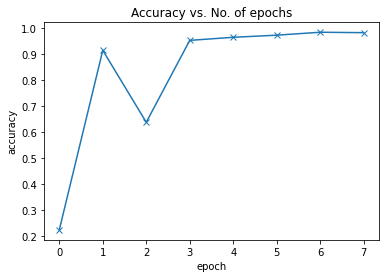

In [ ]:
# Validation Accurasi tiap epochs
plot_accuracies(history)

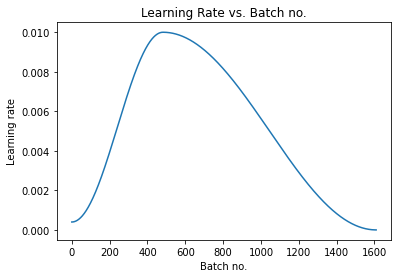

In [ ]:
# Learning Rate overtime
plot_lrs(history)

### Testing :""

In [ ]:
test_dir = "/content/drive/MyDrive/TA-GROUP11/DATASET"
test = ImageFolder(test_dir, transform=transforms.ToTensor())

In [ ]:
test_images = sorted(os.listdir(test_dir + '/DATA_TESTING')) # since images in test folder are in alphabetical order
test_images

['00a14441-7a62-4034-bc40-b196aeab2785___RS_NLB 3932.JPG',
 '00a20f6f-e8bd-4453-9e25-36ea70feb626___RS_GLSp 4655.JPG',
 '00a55069-3fa3-405b-8d87-4d3408a6ed98___RS_NLB 3645.JPG',
 '0a01cc10-3892-4311-9c48-0ac6ab3c7c43___RS_GLSp 9352.JPG',
 '0a11f9e8-7357-48c2-8550-daeae59a1e76___RS_NLB 3588.JPG',
 '0a1a49a8-3a95-415a-b115-4d6d136b980b___R.S_HL 8216 copy.jpg',
 '0a2dec45-729b-4825-b814-a73d14e8c7fe___R.S_HL 8211 copy.jpg',
 '0a403456-5c5e-4aad-aa89-a118175c6ddd___RS_GLSp 4501.JPG',
 '0a5cb475-a6e8-4233-b251-bc5165868730___R.S_HL 7978 copy.jpg',
 '0a62fe5a-22db-42e2-bca0-53a8dcfd8129___RS_NLB 0810.JPG',
 '0a68ef5a-027c-41ae-b227-159dae77d3dd___R.S_HL 7969 copy.jpg',
 '0a72d779-4df2-4365-9251-1733a1a1085c___R.S_HL 7992 copy 2.jpg',
 '0abbec2f-123f-4ae1-a9b7-8babbe8d0e89___RS_NLB 3685.JPG',
 '0b5492ee-253d-4a13-ad5a-780cb954b09a___RS_GLSp 4615 copy.jpg',
 'RS_Rust 1563.JPG',
 'RS_Rust 1564.JPG',
 'RS_Rust 1565.JPG',
 'RS_Rust 1566.JPG',
 'RS_Rust 1567.JPG']

In [ ]:
# Helper function
# Predict Image
def predict_image(img, model):
    """Converts image to array and return the predicted class
        with highest probability"""
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label

    return train.classes[preds[0].item()]

In [ ]:
print(type(test))
print("Len of Test %s"%len(test))

<class 'torchvision.datasets.folder.ImageFolder'>
Len of Test 9204


In [ ]:
# predicting first image
ti = 18
img, label = test[ti]
plt.imshow(img.permute(1, 2, 0))
print('Label:', test_images[ti], ', Predicted:', predict_image(img, model))

NameError: ignored

In [ ]:
# getting all predictions (actual label vs predicted)
test_images.sort()
for i, (img, label) in enumerate(test):
   if(i < len(test_images)):
     print('Label:', test_images[i], ', Predicted:', predict_image(img, model))

Label: 00a14441-7a62-4034-bc40-b196aeab2785___RS_NLB 3932.JPG , Predicted: Training_NLB
Label: 00a20f6f-e8bd-4453-9e25-36ea70feb626___RS_GLSp 4655.JPG , Predicted: Training_GLS
Label: 00a55069-3fa3-405b-8d87-4d3408a6ed98___RS_NLB 3645.JPG , Predicted: Training_NLB
Label: 0a01cc10-3892-4311-9c48-0ac6ab3c7c43___RS_GLSp 9352.JPG , Predicted: Training_GLS
Label: 0a11f9e8-7357-48c2-8550-daeae59a1e76___RS_NLB 3588.JPG , Predicted: Training_NLB
Label: 0a1a49a8-3a95-415a-b115-4d6d136b980b___R.S_HL 8216 copy.jpg , Predicted: Training_HL
Label: 0a2dec45-729b-4825-b814-a73d14e8c7fe___R.S_HL 8211 copy.jpg , Predicted: Training_HL
Label: 0a403456-5c5e-4aad-aa89-a118175c6ddd___RS_GLSp 4501.JPG , Predicted: Training_GLS
Label: 0a5cb475-a6e8-4233-b251-bc5165868730___R.S_HL 7978 copy.jpg , Predicted: Training_HL
Label: 0a62fe5a-22db-42e2-bca0-53a8dcfd8129___RS_NLB 0810.JPG , Predicted: Training_NLB
Label: 0a68ef5a-027c-41ae-b227-159dae77d3dd___R.S_HL 7969 copy.jpg , Predicted: Training_HL
Label: 0a72d7

### Saving Model

In [ ]:
MODEL_DIR = '/content/drive/MyDrive/TA-GROUP11/Model'
__PTH_FORMAT = '.pth'

In [ ]:
# Check current list model
os.listdir(MODEL_DIR)
model_list = os.listdir(MODEL_DIR)
model_list

['plant-disease-model-complete.pth',
 'plant-disease-model.pth',
 'plant-disease-model-complete-2.pth',
 'plant-disease-model-2.pth',
 'plant-disease-model-3.pth',
 'plant-disease-model-complete-3.pth',
 'plant-disease-model4.pth',
 'plant-disease-model-complete4.pth',
 'plant-disease-model5.pth',
 'plant-disease-model-complete5.pth',
 'plant-disease-model-6.pth',
 'plant-disease-model-complete-6.pth']

In [ ]:
# Our model name have number version in the end of name file, so i will get the current last model from our MODEL_DIR
# a new model will be current_index + 1
cur_idx = int(len(model_list)/2)
cur_idx

5

In [ ]:
# saving to the kaggle working directory
FILE_NAME = '/plant-disease-model-'+str(cur_idx+1)
PATH = MODEL_DIR + FILE_NAME + __PTH_FORMAT
print("Saving Model into %s"%PATH)
torch.save(model.state_dict(), PATH)

Saving Model into /content/drive/MyDrive/TA-GROUP11/Model/plant-disease-model-6.pth


In [ ]:
# saving the entire model to working directory
# saving to the kaggle working directory
FILE_NAME = '/plant-disease-model-complete-'+str(cur_idx+1)
PATH = MODEL_DIR + FILE_NAME + __PTH_FORMAT
print("Saving Model into %s"%PATH)
torch.save(model, PATH)

Saving Model into /content/drive/MyDrive/TA-GROUP11/Model/plant-disease-model-complete-6.pth


### Confusion Matrix :D

In [ ]:
from sklearn.metrics import confusion_matrix


In [ ]:
def confusion_matrix(preds, labels, conf_matrix, title='Confusion matrix', cmap=plt.cm.Blues):
    preds = torch.argmax(preds, 1)
    for p, t in zip(preds, labels):
        conf_matrix[p, t] += 1

    #print(conf_matrix)
    #plt.imshow(conf_matrix)
    TP = conf_matrix.diag()
    for c in range(n_classes):
        idx = torch.ones(n_classes).byte()
        idx[c] = 0
        TN = conf_matrix[idx.nonzero()[:,None], idx.nonzero()].sum()
        FP = conf_matrix[c, idx].sum()
        FN = conf_matrix[idx, c].sum()

        Recall = (TP[c] / (TP[c]+FN))
        precision = (TP[c] / (TP[c]+FP))
        f1 = (2 * ((precision * Recall)/(precision + Recall)))

        #print('Class {}\nTP {}, TN {}, FP {}, FN {}'.format(c, TP[c], TN, FP, FN))
        #print('Sensitivity = {}'.format(sensitivity))
        #print('Specificity = {}'.format(specificity))
            
    return conf_matrix

In [ ]:
# n_classes = len(test.classes)
# n_classes
# confusion_matr = torch.zeros(n_classes, n_classes)
# conf_matrix = confusion_matrix(output, labels, confusion_matr)